In [2]:
%load_ext autoreload
%autoreload 2

import os, torch, click, numpy as np
import datetime

import swyft
from utils import *
from plot import *

from tqdm import tqdm
from data_mgmt import get_paths, get_ids
import pickle




DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top

import matplotlib.colors
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams.update({'font.size': 15})



In [3]:
m = 1
nsub = 1
nsim = 10000
nmc = 1
npred = 0 #nsim
# sigmas = [0.0, 0.1, 0.5, 1.0, 2.0, 100.0] 
sigma = 0.0
zeros = ['toy', 'real']

entries = []
for zero in zeros:
    entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,zero=zero)
    entries.append(entry)
    
    print(entry)
entries = np.array(entries)
n_entries = len(entries)

{'m': 1, 'nsub': 1, 'nsim': 10000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'toy'}
{'m': 1, 'nsub': 1, 'nsim': 10000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'real'}


In [4]:
def get_pred(entry):
    _, _, _, pred_path = get_paths(entry)
    
    with open(pred_path, 'rb') as f:
        pred = pickle.load(f)
        
#     post_norm, posts, target, obs0, v0, obs0_i = list(pred.values())
        
    return list(pred.values())

post_norms_all = []
postss_all = []
targets_all = []
obs0s_all = []
v0s_all = []
obs0_is_all = []

for entry in entries:
    post_norms, postss, targets, obs0s, v0s, obs0_is = get_pred(entry)
    
    post_norms_all.append(post_norms)
    postss_all.append(postss)
    targets_all.append(targets)
    obs0s_all.append(obs0s)
    v0s_all.append(v0s)
    obs0_is_all.append(obs0_is)
    

In [5]:
def get_f(posts, targets, x):
    
    x1, x2 = x[:-1], x[1:]
    
    
    def f3(xi, xj):
        y = targets[(posts > xi) & (posts <= xj)]
        return y.sum() / len(y) if y.sum() != 0 else 0

    return np.array([f3(xi, xj) for xi, xj in zip(x1, x2)])

In [6]:
def get_tc(i, v0, target):
    y, x, m = v0.reshape(-1, 3).T
#     m_i = np.where(target == 1)[0]
#     target_coords = np.array((m_i, x, y)).T
    
    m_i = np.full(len(x), i)
    target_coords = np.array((m_i, x, y)).T

    return target_coords

def get_target_coords(i, v0s):
    return np.concatenate([get_tc(j, v0s[j], targets[j]) for j in range(i)])

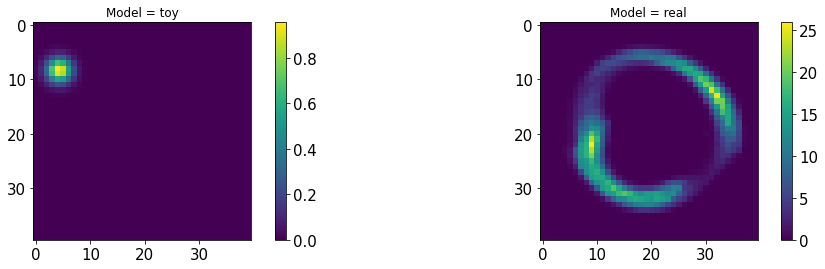

In [18]:
plt_imshow( np.array([obs0s[0] for obs0s in obs0s_all]),
           nrows = 1,
           titles = [f"Model = {entry['zero']}" for entry in entries], 
           cbar = True, tl = True, y = 4,
          )

toy


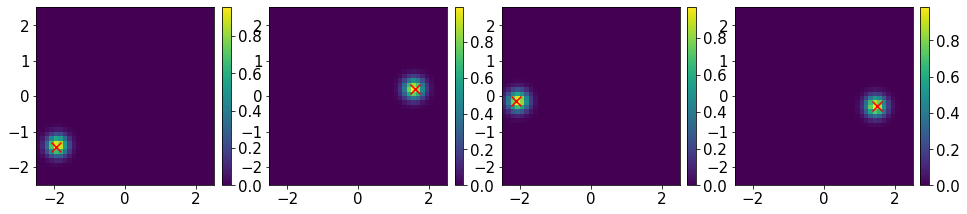

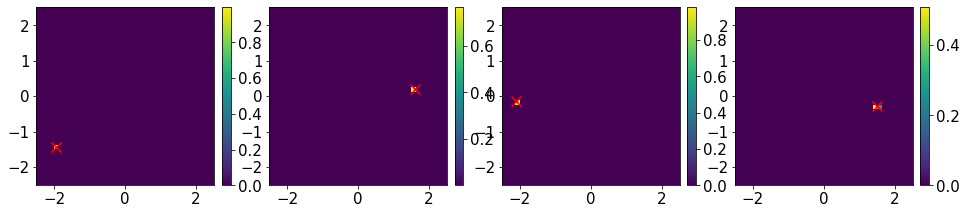

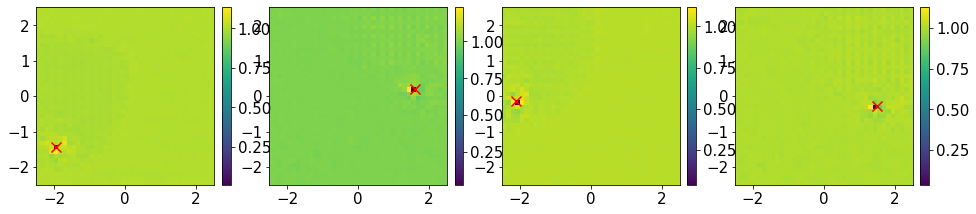

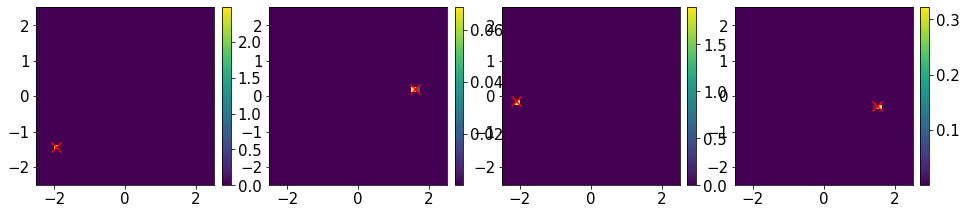

real


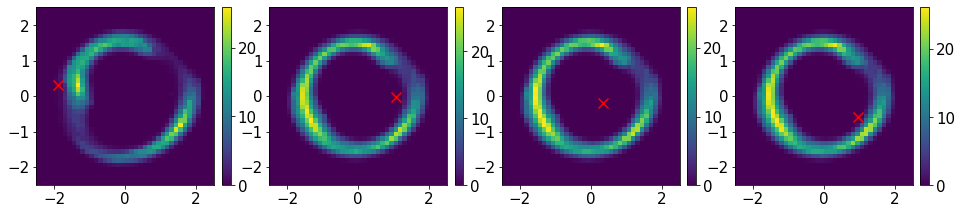

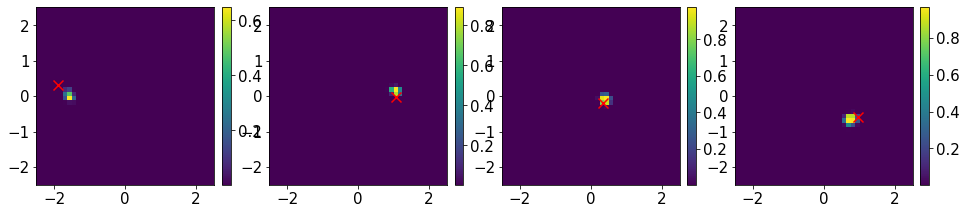

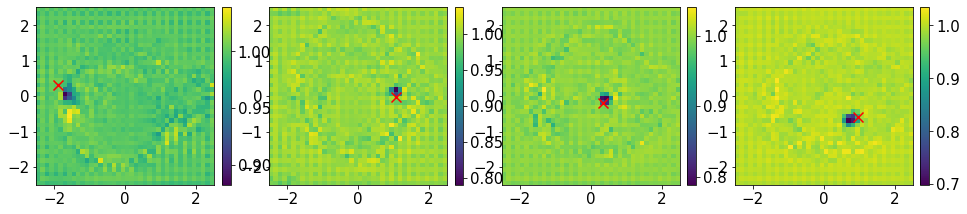

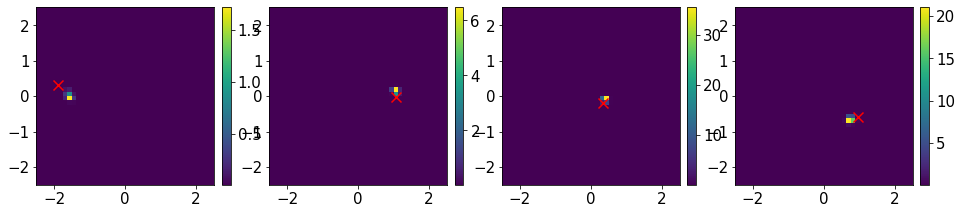

In [19]:

for entry in entries:
    print(entry['zero'])
    post_norms, postss, targets, obs0s, v0s, obs0_is = get_pred(entry)
    
    l = 4
    
    plots = [obs0s, post_norms.squeeze(), postss[:,0], postss[:,1]]
    
    for plot in plots:
        plt_imshow( plot[:l], target_coords = get_target_coords(l, v0s), **imkwargs, cbar = True)

    
    
    
#     plt_imshow( obs0s[:l], target_coords = get_target_coords(l, v0s), **imkwargs, cbar = True)
#     plt_imshow( post_norms.squeeze()[:l], target_coords = get_target_coords(l, v0s), **imkwargs, cbar = True)


In [20]:
def temp_prior(entries):
    L = 40
    priors =  [entry['nsub'] / (L*L) / entry['nmc']  for entry in entries]
    assert all([prior == priors[0] for prior in priors])
    return priors[0]
        
prior_freq = temp_prior(entries)

In [21]:
n_alpha = 50
alpha_edges = np.linspace(0, 1, n_alpha)
alpha_centers = (alpha_edges[:-1] + alpha_edges[1:])/2
# alpha_edges, alpha_centers

In [26]:
parms = np.polyfit(alpha_centers, fs_raw.T, 3).T

posts_calib_all_fit = []

for posts, parm in zip(post_norms_all, parms):
    posts_calib_fit = np.poly1d(parm)(posts) 
    posts_calib_all_fit.append(posts_calib_fit)
    
fs_calib_fit = np.array([get_f(posts_calib_fit, targets, alpha_edges) for posts_calib_fit, targets in zip(posts_calib_all_fit, targets_all)])

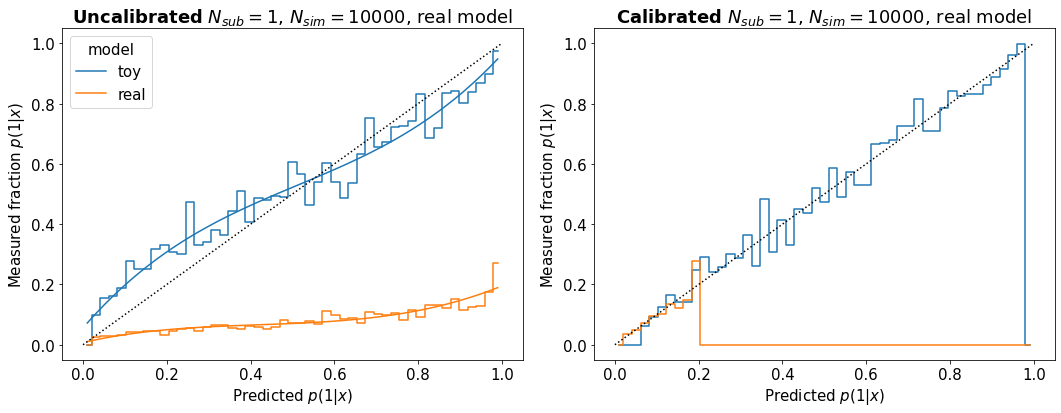

In [28]:
fig, axs = plt.subplots(1, 2, figsize = (15, 6), tight_layout = True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
titles = ['Uncalibrated', 'Calibrated']

for ax, fs, title in zip(axs, [fs_raw, fs_calib_fit], titles):
    

    for f, entry, color, parm in zip(fs, entries, colors, parms):
        ax.step(alpha_centers, f, label = f"{entry['zero']}", where='mid', color = color)
        if ax == axs[0]:
            ax.plot(alpha_centers, np.poly1d(parm)(alpha_centers), color = color)
    ax.plot([0, 1], [0, 1], "k:")
    ax.set_xlabel(r'Predicted $p(1|x)$')
    ax.set_ylabel(r'Measured fraction $p(1|x)$')
    ax.set_title(rf'$\bf{title}$ $N_{{sub}} = {nsub}$, $N_{{sim}} = {nsim}$, {zero} model')
axs[0].legend(title = r'model')

plt.show()

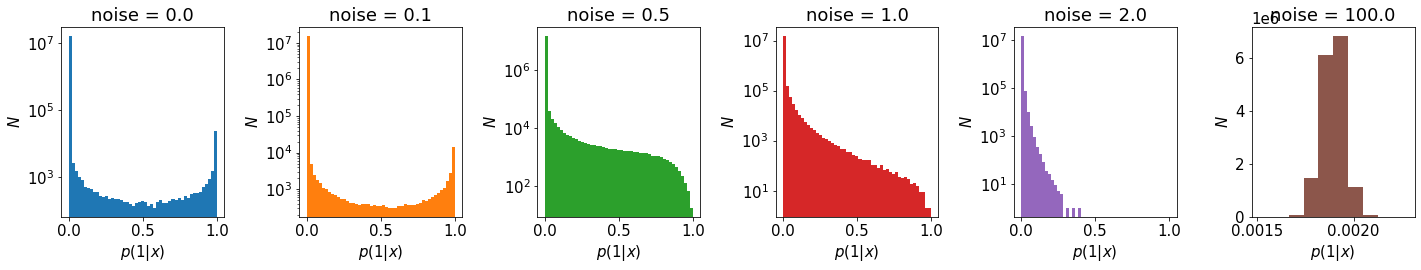

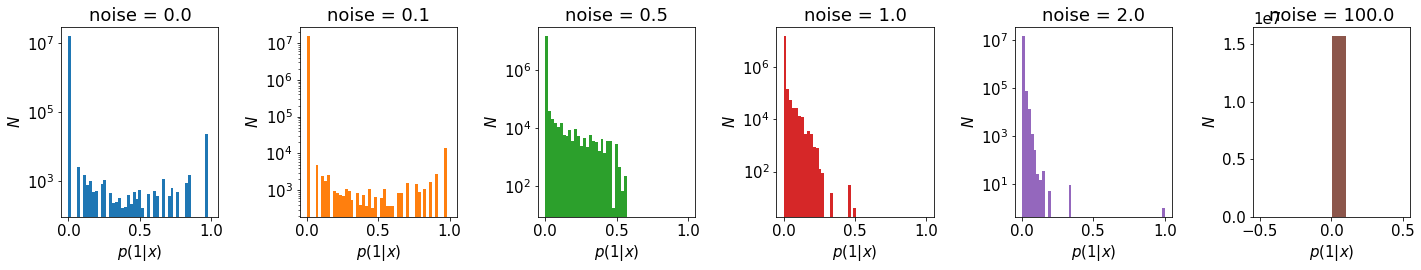

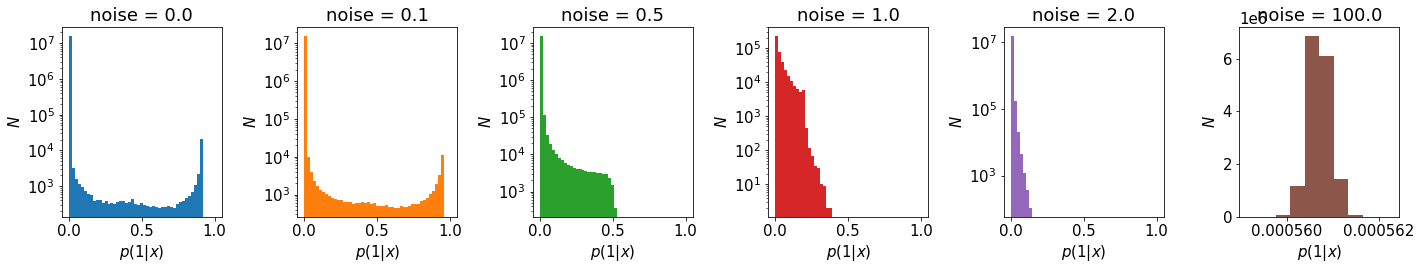

In [19]:
for posts_alls in [posts_all, posts_calib_all, posts_calib_all_fit]:
    fig, axs = plt.subplots(1, n_entries, figsize = (20, 4), tight_layout = True)


    for ax, posts, entry, color in zip(axs[:-1], posts_alls, entries, colors):
        ax.hist(posts.flatten(), bins = alpha_edges, color = color)
        ax.set_yscale('log')
        ax.set_xlabel(r'$p(1|x)$')
        ax.set_ylabel(r'$N$')
        ax.set_title(f"noise = {entry['sigma']}")


    for ax, entry, posts, color in zip(axs[-1:], entries[-1:], posts_alls[-1:], colors[5:6]):
        h, b, _  = ax.hist(posts.flatten(), color = color)
        ax.set_xlabel(r'$p(1|x)$')
        ax.set_ylabel(r'$N$')
        ax.set_title(rf"noise = {entry['sigma']}")
#         ax.axvline(x = prior_freq, ymin = 0, ymax = max(h))


    plt.show()

In [20]:
assert 1 == 2

AssertionError: 

In [ ]:
fig, axs = plt.subplots(1, n_entries, figsize = (20, 4), tight_layout = True)

    
for ax, posts, entry, color in zip(axs[:-1], posts_all, entries, colors):
    ax.hist(posts.flatten(), bins = alpha_edges, color = color)
    ax.set_yscale('log')
    ax.set_xlabel(r'$p(1|x)$')
    ax.set_ylabel(r'$N$')
    ax.set_title(f"noise = {entry['sigma']}")
    

for ax, entry, posts, color in zip(axs[-1:], entries[-1:], posts_all[-1:], colors[5:6]):
    h, _, _  = ax.hist(posts[:10].flatten(), color = color)
    ax.set_xlabel(r'$p(1|x)$')
    ax.set_ylabel(r'$N$')
    ax.set_title(rf"noise = {entry['sigma']}")
    ax.axvline(x = prior_freq, ymin = 0, ymax = max(h))


plt.show()

In [ ]:
plots = [posts, posts2, targets]

for plot in plots:
    plt_imshow( plot[:4].squeeze(), cbar = True, tl = True)
    plt_imshow( plot[:4].squeeze(), cbar = True, tl = True, zlog = True)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 6), tight_layout = True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
titles = [r'$p(1|x)>\alpha$', r'$\alpha<p(1|x)<\alpha$', r'$p(1|x)<\alpha$']


for ax, fs, alpha, title in zip(axs, ff, [alpha_edges[:-1], alpha_centers, alpha_edges[1:]], titles):
    for f, entry, color in zip(fs, entries, colors):
        ax.step(alpha, f, label = f"{entry['sigma']}", where='mid', color = color)
#     ax.plot([0, 1], [0, 1], "k:")
    # ax.plot([0, 1], [prior_freq, prior_freq], "k--")
    ax.set_xlabel(r'Predicted $p(1|x)$')
    ax.set_ylabel(r'Measured fraction $p(1|x)$')
    ax.set_title(title)
#     ax.set_title(rf'$N_{{sub}} = {nsub}$, noise = {sigma}, {zero} model')
ax.legend(title = 'noise')

plt.show()

In [ ]:
from scipy import interpolate
from scipy import stats

In [ ]:
fs_cumsum = np.cumsum(fs_raw, axis = 1)
plt.step(alpha_centers, fs_cumsum.T, where = 'mid')
plt.show()
fs_cumsum /= np.max(fs_cumsum, axis = 1)[:, np.newaxis]

In [ ]:
plt.step(alpha_centers, fs_cumsum.T, where = 'mid')
plt.show()

In [ ]:
plt.plot(fsc.T)

In [ ]:
np.sum(fsc, axis = 1)

In [ ]:
plt.plot(alpha_centers, fsc[1])

In [ ]:
assert 1 === 2

In [ ]:
fs = np.array([get_f(posts, targets, alpha_edges) for posts, targets in zip(posts_all, targets_all)])

In [ ]:
fs_raw == fs_calib